In [ ]:
import yfinance as yf
import pandas as pd
#import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
ticker_symbol = 'AAPL'  # Substitua 'AAPL' pelo ticker do ativo financeiro desejado
start_date = '2022-01-01'  # Defina a data de início do histórico de dados
end_date = '2023-01-01'  # Defina a data de término do histórico de dados
moving_average_window = 20  # Janela da média móvel (20 dias neste exemplo)
num_standard_deviations = 2.5  # Número de desvios padrão para a banda superior e inferior
stop_loss_percent = 0.05  # Valor percentual para o stop loss (5% neste exemplo)

In [ ]:
def download_historical_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Baixar dados históricos do Yahoo Finance
data = download_historical_data(ticker_symbol, start_date, end_date)

In [ ]:
data.head()

In [ ]:
data

In [ ]:
def calculate_cumulative_returns(data):
    data['Returns'] = data['Close'].pct_change()
    data['Position'] = 0  # Inicializa a coluna 'Position'
    data_with_positions = trading_strategy(data, moving_average_window, num_standard_deviations, stop_loss_percent)
    data['Cumulative_Returns'] = (data_with_positions['Returns'] * data_with_positions['Position']).cumsum()
    return data['Cumulative_Returns']

# Calcular os retornos acumulados
data['Cumulative_Returns'] = calculate_cumulative_returns(data)

In [ ]:
data['Cumulative_Returns'].hist()

In [ ]:
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

def calculate_standard_deviation(data, window):
    return data['Close'].rolling(window=window).std()

In [ ]:
def trading_strategy(data, ma_window, num_std, stop_loss_percent):
    data['SMA'] = calculate_moving_average(data, ma_window)
    data['Upper_Band'] = data['SMA'] + (data['Close'].rolling(window=ma_window).std() * num_std)
    data['Lower_Band'] = data['SMA'] - (data['Close'].rolling(window=ma_window).std() * num_std)
    data['Signal'] = 0
    data['Position'] = 0

    for i in range(ma_window, len(data)):
        if data['Close'][i] > data['Upper_Band'][i]:
            data['Signal'][i] = -1  # Sinal de venda
        elif data['Close'][i] < data['Lower_Band'][i]:
            data['Signal'][i] = 1  # Sinal de compra

        if data['Position'][i - 1] == 1 and data['Cumulative_Returns'][i] < (1 - stop_loss_percent):
            data['Signal'][i] = -1  # Aciona o stop loss e vende a posição
            data['Position'][i] = 0
        elif data['Position'][i - 1] == -1 and data['Cumulative_Returns'][i] > 0:
            data['Signal'][i] = 1  # Venda a descoberto, aciona o stop loss e compra a posição
            data['Position'][i] = 0
        else:
            data['Position'][i] = data['Signal'][i]  # Mantém a posição atual

    data.dropna(inplace=True)
    return data


# Aplicar a estratégia de trading com stop loss
data_with_signals = trading_strategy(data, moving_average_window, num_standard_deviations, stop_loss_percent)

In [ ]:
def calculate_drawdown(data):
    data['Peak'] = data['Close'].cummax()
    data['Drawdown'] = (data['Peak'] - data['Close']) / data['Peak']
    return data['Drawdown']

# Calcular o drawdown
data_with_signals['Drawdown'] = calculate_drawdown(data_with_signals)

In [ ]:
# Criar a figura com múltiplos gráficos (subplot)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plotar o gráfico da estratégia na primeira posição do subplot
plot_trading_signals(data_with_signals)

# Plotar o gráfico do drawdown na segunda posição do subplot
plot_drawdown(data_with_signals)

# Plotar o gráfico dos retornos acumulados na terceira posição do subplot
plot_cumulative_returns(data_with_signals)

# Ajustar o layout para evitar sobreposição de elementos
plt.tight_layout()

# Mostrar os gráficos
plt.show()

In [ ]:
def plot_trading_signals(data):
    plt.plot(data.index, data['Close'], label='Preço de Fechamento', color='black')
    plt.plot(data.index, data['SMA'], label='Média Móvel Simples', color='blue')
    plt.fill_between(data.index, data['Upper_Band'], data['Lower_Band'], alpha=0.2, color='gray')
    plt.plot(data[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], '^', markersize=10, color='g', label='Compra')
    plt.plot(data[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], 'v', markersize=10, color='r', label='Venda')
    plt.title('Estratégia de Reversão à Média com 2,5 Desvios Padrão')
    plt.legend()

def plot_drawdown(data):
    plt.plot(data.index, data['Drawdown'], label='Drawdown', color='red')
    plt.fill_between(data.index, data['Drawdown'], alpha=0.2, color='red')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('Drawdown ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Drawdown')
    plt.legend()

def plot_cumulative_returns(data):
    positive_returns = data['Cumulative_Returns'] >= 0
    plt.fill_between(data.index, data['Cumulative_Returns'], where=positive_returns, alpha=0.2, color='green')
    plt.fill_between(data.index, data['Cumulative_Returns'], where=~positive_returns, alpha=0.2, color='red')
    plt.plot(data.index, data['Cumulative_Returns'], color='green' if data['Cumulative_Returns'].iloc[-1] >= 0 else 'red', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('Retornos Acumulados da Estratégia')
    plt.xlabel('Data')
    plt.ylabel('Retornos Acumulados')
    plt.legend()

[*********************100%***********************]  1 of 1 completed


C:\Users\Caíque Miranda\AppData\Local\Temp\ipykernel_11756\3260250946.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = data['Signal'][i]  # Mantém a posição atual
C:\Users\Caíque Miranda\AppData\Local\Temp\ipykernel_11756\3260250946.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][i] = 1  # Sinal de compra
C:\Users\Caíque Miranda\AppData\Local\Temp\ipykernel_11756\3260250946.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

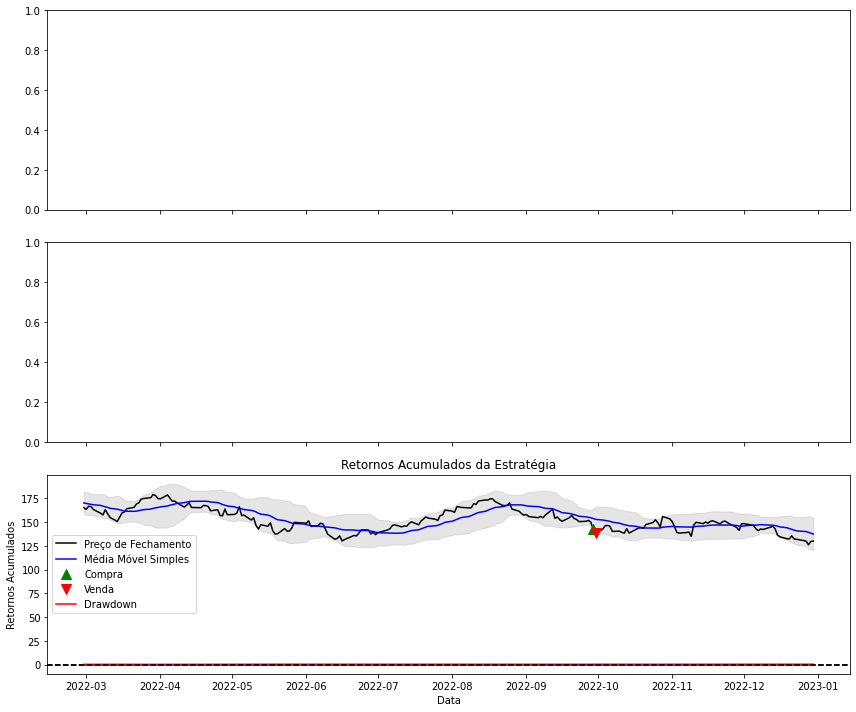

In [1]:
import yfinance as yf
import random
import pandas as pd
import matplotlib.pyplot as plt

def download_historical_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    tamanho_do_dataframe = 251
    data['Cumulative_Returns'] = [random.randint(0, 100) for _ in range(tamanho_do_dataframe)]
    return data

def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

def calculate_standard_deviation(data, window):
    return data['Close'].rolling(window=window).std()

def trading_strategy(data, ma_window, num_std, stop_loss_percent):
    
    data['SMA'] = calculate_moving_average(data, ma_window)
    data['Upper_Band'] = data['SMA'] + (data['Close'].rolling(window=ma_window).std() * num_std)
    data['Lower_Band'] = data['SMA'] - (data['Close'].rolling(window=ma_window).std() * num_std)
    data['Signal'] = 0
    data['Position'] = 0

    for i in range(ma_window, len(data)):
        if data['Close'][i] > data['Upper_Band'][i]:
            data['Signal'][i] = -1  # Sinal de venda
        elif data['Close'][i] < data['Lower_Band'][i]:
            data['Signal'][i] = 1  # Sinal de compra

        if data['Position'][i - 1] == 1 and data['Cumulative_Returns'][i] < (1 - stop_loss_percent):
            data['Signal'][i] = -1  # Aciona o stop loss e vende a posição
            data['Position'][i] = 0
        elif data['Position'][i - 1] == -1 and data['Cumulative_Returns'][i] > 0:
            data['Signal'][i] = 1  # Venda a descoberto, aciona o stop loss e compra a posição
            data['Position'][i] = 0
        else:
            data['Position'][i] = data['Signal'][i]  # Mantém a posição atual

    data.dropna(inplace=True)
    return data

def calculate_drawdown(data):
    data['Peak'] = data['Close'].cummax()
    data['Drawdown'] = (data['Peak'] - data['Close']) / data['Peak']
    return data['Drawdown']

def calculate_cumulative_returns(data):
    data['Returns'] = data['Close'].pct_change()
    data['Position'] = 0  # Inicializa a coluna 'Position'
    data_with_positions = trading_strategy(data, moving_average_window, num_standard_deviations, stop_loss_percent)
    data['Cumulative_Returns'] = (data_with_positions['Returns'] * data_with_positions['Position']).cumsum()
    return data['Cumulative_Returns']

def plot_trading_signals(data):
    plt.plot(data.index, data['Close'], label='Preço de Fechamento', color='black')
    plt.plot(data.index, data['SMA'], label='Média Móvel Simples', color='blue')
    plt.fill_between(data.index, data['Upper_Band'], data['Lower_Band'], alpha=0.2, color='gray')
    plt.plot(data[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], '^', markersize=10, color='g', label='Compra')
    plt.plot(data[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], 'v', markersize=10, color='r', label='Venda')
    plt.title('Estratégia de Reversão à Média com 2,5 Desvios Padrão')
    plt.legend()

def plot_drawdown(data):
    plt.plot(data.index, data['Drawdown'], label='Drawdown', color='red')
    plt.fill_between(data.index, data['Drawdown'], alpha=0.2, color='red')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('Drawdown ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Drawdown')
    plt.legend()

def plot_cumulative_returns(data):
    positive_returns = data['Cumulative_Returns'] >= 0
    plt.fill_between(data.index, data['Cumulative_Returns'], where=positive_returns, alpha=0.2, color='green')
    plt.fill_between(data.index, data['Cumulative_Returns'], where=~positive_returns, alpha=0.2, color='red')
    plt.plot(data.index, data['Cumulative_Returns'], color='green' if data['Cumulative_Returns'].iloc[-1] >= 0 else 'red', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('Retornos Acumulados da Estratégia')
    plt.xlabel('Data')
    plt.ylabel('Retornos Acumulados')
    plt.legend()

if __name__ == "__main__":
    ticker_symbol = 'AAPL'  # Substitua 'AAPL' pelo ticker do ativo financeiro desejado
    start_date = '2022-01-01'  # Defina a data de início do histórico de dados
    end_date = '2023-01-01'  # Defina a data de término do histórico de dados
    moving_average_window = 20  # Janela da média móvel (20 dias neste exemplo)
    num_standard_deviations = 2.5  # Número de desvios padrão para a banda superior e inferior
    stop_loss_percent = 0.05  # Valor percentual para o stop loss (5% neste exemplo)

    # Baixar dados históricos do Yahoo Finance
    data = download_historical_data(ticker_symbol, start_date, end_date)

    # Calcular os retornos acumulados
    data['Cumulative_Returns'] = calculate_cumulative_returns(data)

    # Aplicar a estratégia de trading com stop loss
    data_with_signals = trading_strategy(data, moving_average_window, num_standard_deviations, stop_loss_percent)

    # Calcular o drawdown
    data_with_signals['Drawdown'] = calculate_drawdown(data_with_signals)

    # Criar a figura com múltiplos gráficos (subplot)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Plotar o gráfico da estratégia na primeira posição do subplot
    plot_trading_signals(data_with_signals)

    # Plotar o gráfico do drawdown na segunda posição do subplot
    plot_drawdown(data_with_signals)

    # Plotar o gráfico dos retornos acumulados na terceira posição do subplot
    plot_cumulative_returns(data_with_signals)

    # Ajustar o layout para evitar sobreposição de elementos
    plt.tight_layout()

    # Mostrar os gráficos
    plt.show()
